# Weather Prediction Example
Start by loading historical weather data for a location

In [2]:
from iris.common import spark

In [3]:
ss = spark.getSparkSession('modelDevelTest', numParts=64, maxCores='17', executorCores='1', executorMem='2g')

working in 64 numparts
querying EC2 for cassandra hosts
using spark master(s) spark://10.0.1.250:7077,10.0.1.103:7077
querying EC2 for cassandra hosts
found cassandra hosts ['10.0.1.57', '10.0.1.73', '10.0.1.151', '10.0.1.168', '10.0.1.249', '10.0.1.155', '10.0.1.53', '10.0.1.6', '10.0.1.227', '10.0.1.181', '10.0.1.82', '10.0.1.4', '10.0.1.101', '10.0.1.122', '10.0.1.107', '10.0.1.59', '10.0.1.47']
using cassandra hosts 10.0.1.57,10.0.1.73,10.0.1.151,10.0.1.168,10.0.1.249,10.0.1.155,10.0.1.53,10.0.1.6,10.0.1.227,10.0.1.181,10.0.1.82,10.0.1.4,10.0.1.101,10.0.1.122,10.0.1.107,10.0.1.59,10.0.1.47
fetching a spark session for app modelDevelTest on spark://10.0.1.250:7077,10.0.1.103:7077
setting custom vpn ports and addresses for user alec
setting spark event logs to go to /eventlogs for the history server
Using dynamic executors for better resource sharing
setting graph operations to checkpoint to s3 every iteration


In [4]:
weather = ss.read.format("org.apache.spark.sql.cassandra")\
    .options(table="weather_noaa", keyspace="weather").load().persist()

In [5]:
# complete this section by fetching the data locally as a pandas data frame
weatherLocal = weather.where('zipcode == 23250').toPandas()

# Prep inputs for modeling
First we make a numeric time scale, though just having them in order of date is sufficient

In [7]:
day_zero = weatherLocal['date'].min()

In [8]:
weatherLocal.set_index((weatherLocal['date'] - day_zero).apply(lambda d: d.days), inplace=True)
weatherLocal.sort_index(inplace=True)

## Create features
* length of day
* average temperature
* change in average temperature
* change in barometric pressure
* precipitation
* wind speed peak

In [9]:
weatherLocal['precip_total'].fillna(0, inplace=True)

In [10]:
weatherLocal['day_length'] = weatherLocal.apply(lambda r: int(r.sunset) - int(r.sunrise), axis=1)

In [11]:
weatherLocal['tavg'] = (weatherLocal.tmax + weatherLocal.tmin) / 2

In [12]:
weatherLocal['pressure_change'] = weatherLocal['pressure_avg'].pct_change()

In [13]:
weatherLocal['temp_change'] = weatherLocal['tavg'].pct_change()

In [55]:
weather_features = weatherLocal[
    ['day_length', 'tavg', 'tmin', 'tmax', 'temp_change', 'pressure_change', 'precip_total', 'wind_speed_peak']].dropna()

In [56]:
weather_features.iloc[:6]

,day_length,tavg,tmin,tmax,temp_change,pressure_change,precip_total,wind_speed_peak
date,,,,,,,,
1,980,40.0,30.0,50.0,-0.036145,-0.002341,0.83,25.0
2,980,43.0,41.0,45.0,0.075000,-0.006034,0.03,23.0
3,981,42.0,39.0,45.0,-0.023256,0.004722,0.00,18.0
4,981,44.0,35.0,53.0,0.047619,-0.007721,0.00,20.0
5,983,37.5,29.0,46.0,-0.147727,0.002368,0.00,26.0
6,984,30.5,20.0,41.0,-0.186667,0.006412,0.00,22.0


## Normalize inputs for deep learning
Most neural networks expect inputs from -1 to 1

In [57]:
weather_norm = weather_features.apply(lambda c: 0.5 * (c - c.mean()) / c.std())

In [58]:
weather_x = weather_norm.drop('tmax', axis=1)
# shift so that we're trying to predict tomorrow
weather_y = weather_norm['tmax'].shift(-1)

In [59]:
# predict on the last two months
predict_day = weather_x.index[-60]

# Recurrent Neural Network Model
Build a PyTorch model to do time series prediction

In [60]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from datetime import datetime
import pandas as pd
import ggplot as gg

In [61]:
x_train = torch.autograd.Variable(
    torch.from_numpy(weather_x.loc[:predict_day - 1].as_matrix()).float(), requires_grad=False)
x_test = torch.autograd.Variable(
    torch.from_numpy(weather_x.loc[predict_day:].as_matrix()).float(), requires_grad=False)
batch_size = x_train.size()[0]
input_size = len(weather_x.columns)

In [62]:
y_train = torch.autograd.Variable(
    torch.from_numpy(weather_y.loc[:predict_day - 1].as_matrix()).float(), requires_grad=False)
y_test = torch.autograd.Variable(
    torch.from_numpy(weather_y.loc[predict_day:].as_matrix()).float(), requires_grad=False)

In [63]:
class WeatherNet(torch.nn.Module):
    hidden_layers = 1
    hidden_size = 8
    
    def __init__(self):
        super(WeatherNet, self).__init__()
        # use a small hidden layer since we have such narrow inputs
        self.rnn1 = nn.GRU(input_size=input_size,
                           hidden_size=self.hidden_size,
                           num_layers=self.hidden_layers)
        self.dense1 = nn.Linear(self.hidden_size, 1)

    def forward(self, x, hidden):
        x_batch = x.view(len(x), 1, -1)
        x_r, hidden = self.rnn1(x_batch, hidden)
        x_o = self.dense1(x_r)
        return x_o, hidden

    def init_hidden(self, batch_size):
        return Variable(torch.randn(self.hidden_layers, 1, self.hidden_size))

In [64]:
torch.manual_seed(0)
model = WeatherNet()
print(model)
criterion = nn.MSELoss(size_average=True)
# use LBFGS as optimizer since we can load the whole data to train
#optimizer = optim.LBFGS(seq.parameters())
optimizer = torch.optim.Adadelta(model.parameters())

WeatherNet (
  (rnn1): GRU(7, 8)
  (dense1): Linear (8 -> 1)
)


In [65]:
hidden = model.init_hidden(batch_size)

for i in range(42):
    def closure():
        model.zero_grad()
        hidden = model.init_hidden(batch_size)
        out, hidden = model(x_train, hidden)
        loss = criterion(out, y_train)
        if i % 2 == 0:
            print('{:%H:%M} epoch {} loss: {}'.format(datetime.now(), i, loss.data.numpy()[0]))
        loss.backward()
        return loss
    optimizer.step(closure)

21:16 epoch 0 loss: 0.2200760692358017
21:17 epoch 2 loss: 0.197604700922966
21:17 epoch 4 loss: 0.17714084684848785
21:17 epoch 6 loss: 0.15806159377098083
21:17 epoch 8 loss: 0.14061188697814941
21:17 epoch 10 loss: 0.12431588768959045
21:17 epoch 12 loss: 0.11045175790786743
21:17 epoch 14 loss: 0.09928999841213226
21:17 epoch 16 loss: 0.08926115185022354
21:17 epoch 18 loss: 0.08154968917369843
21:17 epoch 20 loss: 0.07631676644086838
21:17 epoch 22 loss: 0.07259219139814377
21:17 epoch 24 loss: 0.06930436939001083
21:18 epoch 26 loss: 0.06692928075790405
21:18 epoch 28 loss: 0.06559289991855621
21:18 epoch 30 loss: 0.06408791989088058
21:18 epoch 32 loss: 0.06281154602766037
21:18 epoch 34 loss: 0.06194452568888664
21:18 epoch 36 loss: 0.06118372082710266
21:18 epoch 38 loss: 0.05996329337358475
21:18 epoch 40 loss: 0.059083107858896255


# Predict
Keep the current hidden state of the model and run it forward without updating parameters

In [66]:
y_pred, new_hidden = model(x_test, hidden)

In [67]:
predictions = pd.DataFrame(y_pred.view(len(y_pred), -1).data.numpy(), columns=['tmax_norm'])
predictions['actual'] = 'predicted'

In [68]:
actuals = pd.DataFrame(y_test.data.numpy(), columns=['tmax_norm'])
actuals['actual'] = 'actual'

In [69]:
# join for plotting purposes
eval_data = pd.concat([predictions, actuals])
eval_data['day'] = eval_data.index

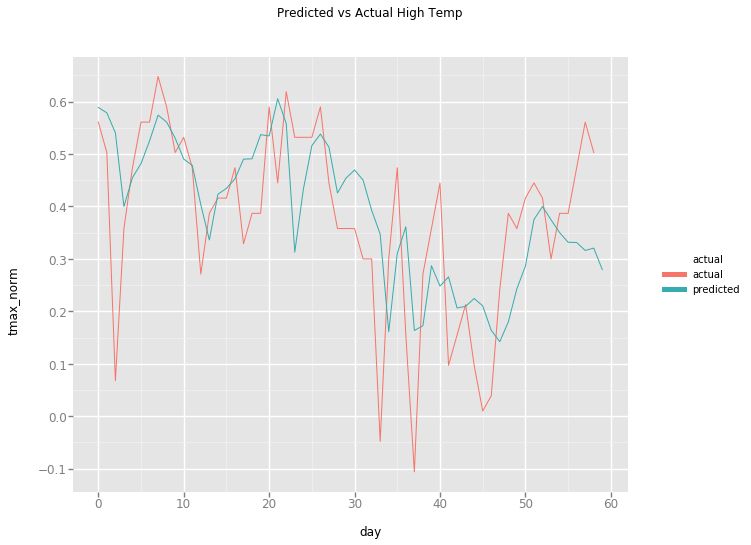

<ggplot: (8743715045275)>

In [74]:
gg.ggplot(gg.aes(x='day', y='tmax_norm', color='actual'),
          data=eval_data) + gg.geom_line() + gg.ggtitle("Predicted vs Actual High Temp")